In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))]
)

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz
9920512it [00:04, 2274299.31it/s]
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz
32768it [00:00, 59831.01it/s]
0it [00:00, ?it/s]Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
1654784it [00:01, 959489.27it/s]
0it [00:00, ?it/s]Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
8192it [00:00, 21044.73it/s]Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!



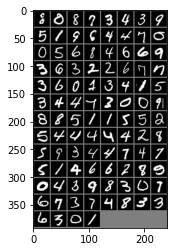

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x32 -> 26x26x32
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x64 -> 24x24x64 
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64
        self.dropout1 = nn.Dropout2d()
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.dropout2 = nn.Dropout2d()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 12 * 12 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

net = Net()

In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(3):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[{:d}, {:5d}] loss: {:.3f}'
                    .format(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.225
[1,   200] loss: 1.636
[1,   300] loss: 0.858
[1,   400] loss: 0.601
[1,   500] loss: 0.522
[1,   600] loss: 0.491
[2,   100] loss: 0.451
[2,   200] loss: 0.409
[2,   300] loss: 0.383
[2,   400] loss: 0.380
[2,   500] loss: 0.341
[2,   600] loss: 0.335
[3,   100] loss: 0.326
[3,   200] loss: 0.316
[3,   300] loss: 0.297
[3,   400] loss: 0.307
[3,   500] loss: 0.291
[3,   600] loss: 0.274
Finished Training


In [7]:
PATH = './mnist2_net.pth'
torch.save(net.state_dict(), PATH)

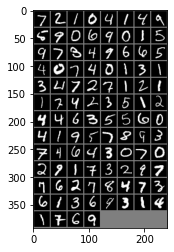

GroundTruth:      7     2     1     0


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:      7     2     1     0


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 92 %


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 96 %
Accuracy of     1 : 95 %
Accuracy of     2 : 97 %
Accuracy of     3 : 94 %
Accuracy of     4 : 95 %
Accuracy of     5 : 94 %
Accuracy of     6 : 92 %
Accuracy of     7 : 85 %
Accuracy of     8 : 89 %
Accuracy of     9 : 85 %
